In [1]:
from __future__ import division  # Python 2 users only
from __future__ import print_function

__doc__ = """ numpy utility functions used for tSNE modelling"""

import numpy as np

In [2]:
def Hbeta_vec(distances, betas):
    """
    Function that computes the Gaussian kernel values given a vector of
    squared Euclidean distances, and the precision of the Gaussian kernel.
    The function also computes the perplexity of the distribution.
    From Parametric t-SNE for matlab at https://lvdmaaten.github.io/tsne/
    Parameters
    ----------
    distances: 2-d array_like, (N,N)
        Square matrix of distances between data points
    betas: 1-d array_like, (N,)
        Vector of precisions of the Gaussian kernel. beta = (2 sigma**2)^-1
    Returns
    -------
    H: 1-d array_like, (N,)
        Entropy of each point
    p_matr: 2-d array_like, (N,N)
        array of probability values
        The scalar formula for p_matr is:
        p_matr = np.exp(-D * beta) / sum(np.exp(-D * beta))
        This funcion is vectorized and calculates the full P matrix
    """
    beta_matr = (betas[:,np.newaxis] * np.ones_like(distances))
    p_matr = np.exp(-distances * beta_matr)
    sumP = np.sum(p_matr, axis=1)
    H = np.log(sumP) + (betas * np.sum(distances * p_matr, axis=1)) / sumP
    p_matr = p_matr / (sumP[:,np.newaxis]*np.ones_like(p_matr))
    
    return H, p_matr


def Hbeta_scalar(distances, beta):
    """
    Function that computes the Gaussian kernel values given a vector of
    squared Euclidean distances, and the precision of the Gaussian kernel.
    The function also computes the perplexity of the distribution.
    From Parametric t-SNE for matlab at https://lvdmaaten.github.io/tsne/
    Parameters
    ----------
    distances: 1-d array_like, (N,)
        Distance between the current data point and all others
    beta: float
        Precision of the Gaussian kernel. beta = (2 sigma**2)^-1
    Returns
    -------
    H: float
        Entropy
    p_matr: 1-d array_like, (N,)
        array of probability values
        p_matr = np.exp(-D * beta) / sum(np.exp(-D * beta))
    """

    p_matr = np.exp(-distances * beta)
    sumP = np.sum(p_matr)
    H = np.log(sumP) + (beta * np.sum(distances * p_matr)) / sumP
    p_matr = p_matr / sumP
    
    return H, p_matr


def get_squared_cross_diff_np(X_):
    """Compute squared differences of sample data vectors.
        Z_ij = ||x_i - x_j||^2, where x_i = X_[i, :]
    Parameters
    ----------
    X_ : 2-d array_like, (N, D)
        Calculates outer vector product
        This is the current batch of input data; `batch_size` x `dimension`
    Returns
    -------
    Z_ij: 2-d array_like, (N, N)
        `batch_size` x `batch_size`
        Matrix of squared differences between x_i and x_j
    """
    batch_size = X_.shape[0]
    
    expanded = np.expand_dims(X_, 1)
    # "tiled" is now stacked up all the samples along dimension 1
    tiled = np.tile(expanded, np.stack([1, batch_size, 1]))
    
    tiled_trans = np.transpose(tiled, axes=[1,0,2])
    
    diffs = tiled - tiled_trans
    sum_act = np.sum(np.square(diffs), axis=2)
    
    return sum_act


def get_Lmax(num_points):
    return np.floor(np.log2(num_points/4.0))


def get_multiscale_perplexities(num_points):
    """From
    Multiscale stochastic neighbor embedding: Towards parameter-free dimensionality reduction"""
    Lmax = get_Lmax(num_points)
    _L_vals = np.arange(2, Lmax)
    perplexities = 2.0**(_L_vals)
    return perplexities


def calc_betas_loop(indata, perplexity, tol=1e-4, max_tries=50):
    """
    Calculate beta values for a desired perplexity via binary search
    Uses a loop; could be made faster with cython
    In my tests, vectorized version (calc_betas_vec) doesn't end up much faster
    likely due to higher memory usage
    Parameters
    ----------
    indata: 2-d array_like, (N,D)
    perplexity: float
        Desired perplexity. See literature on tSNE for details.
        Roughly speaking, this is the number of points which should be considered
        when calculating distances
    tol: float, optional
        Absolute tolerance in the entropy for calculating the beta values
        Once entropy stops shifting by this amount the search stops
    max_tries: int, optional
        Maximum number of iterations to use. Default 50.
    Returns
    -------
    betas: 1-D array_like, (N,)
        Calculated beta values
    Hs: 1-d array_like, (N,)
        Entropy at each point given the
    p_matr: 2-d array_like, (N,N)
        Probability matrix between each pair of points
    """
    logPx = np.log(perplexity)
    num_samps = indata.shape[0]

    beta_init = np.ones([num_samps], dtype=float)
    betas = beta_init.copy()
    p_matr = np.zeros([num_samps, num_samps])
    Hs = beta_init.copy()
    
    in_sq_diffs = get_squared_cross_diff_np(indata)

    loop_samps = range(num_samps)
    for ss in loop_samps:
        betamin = -np.inf
        betamax = np.inf
        
        Di = in_sq_diffs[ss, :]
        H, thisPx = Hbeta_scalar(Di, betas[ss])
        del H
        Hdiff = 100*tol
        
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:
            # Compute the Gaussian kernel and entropy for the current precision
            H, thisPx = Hbeta_scalar(Di, betas[ss])
            Hdiff = H - logPx
            tries = tries + 1
            
            if Hdiff > 0.0:
                betamin = betas[ss]
                if np.isinf(betamax):
                    betas[ss] = betas[ss] * 2.0
                else:
                    betas[ss] = (betas[ss] + betamax) / 2.0
            else:
                betamax = betas[ss]
                if np.isinf(betamin):
                    betas[ss] = betas[ss] / 2.0
                else:
                    betas[ss] = (betas[ss] + betamin) / 2.0
        
        # Set the final row of P
        p_matr[ss, :] = thisPx
        Hs[ss] = H

    return betas, Hs, p_matr


def _calc_betas_vec(indata, perplexity, tol=1e-4, max_tries=50):
    """
    Calculate beta values for a desired perplexity via binary search
    Vectorized version
    Not documented because not used
    """
    logPx = np.log(perplexity)
    num_samps = indata.shape[0]
    
    beta_init = np.ones([num_samps], dtype=float)
    in_sq_diffs = get_squared_cross_diff_np(indata)

    betamins = -np.inf*beta_init.copy()
    betamaxs = np.inf*beta_init.copy()
    betas = beta_init.copy()
    
    # Initialize Hdiffs as some large amount
    overall_Hdiff = 100*tol*np.ones_like(beta_init)
    tries = 0
    
    while tries < max_tries:

        # At any given iteration we are only operating on a subset of indices
        use_locs = np.where(np.abs(overall_Hdiff) > tol)[0]

        if len(use_locs) == 0:
            break
        
        # Compute the Gaussian kernel and entropy for the current precision
        Di_matr = in_sq_diffs[use_locs,:]
        curH, curP_matr = Hbeta_vec(Di_matr, betas[use_locs])
        Hdiff = curH - logPx
        overall_Hdiff[use_locs] = Hdiff

        # Some locations should have higher beta, some lower beta
        increase_beta_locs = use_locs[Hdiff > 0.0]
        decrease_beta_locs = use_locs[Hdiff <= 0.0]
        
        overlap = np.intersect1d(increase_beta_locs, decrease_beta_locs)
        assert len(overlap) == 0
        
        if len(increase_beta_locs) > 0:
            betamins[increase_beta_locs] = betas[increase_beta_locs]
            betas[increase_beta_locs] = np.where(np.isinf(betamaxs[increase_beta_locs]), betas[increase_beta_locs]*2.0, (betas[increase_beta_locs] + betamaxs[increase_beta_locs])/2.0)
        
        if len(decrease_beta_locs) > 0:
            betamaxs[decrease_beta_locs] = betas[decrease_beta_locs]
            betas[decrease_beta_locs] = np.where(np.isinf(betamins[decrease_beta_locs]), betas[decrease_beta_locs]/2.0, (betas[decrease_beta_locs] + betamins[decrease_beta_locs])/2.0)
            
        tries += 1
    
    finalH, p_matr = Hbeta_vec(in_sq_diffs, betas)
    
    return betas, p_matr, finalH


In [3]:
#!/usr/bin/python
from __future__ import division  # Python 2 users only
from __future__ import print_function

__doc__= """ 
Module for building a parametric tSNE model. 
Trains a neural network on input data. 
One can then transform other data based on this model

Main reference:
van der Maaten, L. (2009). Learning a parametric embedding by preserving local structure. RBM, 500(500), 26.
See README.md for others
"""

import datetime
import functools

import numpy as np

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

# from .utils import calc_betas_loop
# from .utils import get_squared_cross_diff_np

DEFAULT_EPS = 1e-7


In [4]:

from sklearn.decomposition import PCA

In [5]:


def _make_P_ji(input, betas, in_sq_diffs=None):
    """Calculate similarity probabilities based on input data
    Parameters
    ----------
    input : 2d array_like, (N, D)
        Input data which we wish to calculate similarity probabilities
    betas : 1d array_like, (N, P)
        Gaussian kernel used for each point.
    Returns
    -------
    P_ji : 2d array_like, (N,N,P)
        Similarity probability matrix
    """
    if not in_sq_diffs:
        in_sq_diffs = get_squared_cross_diff_np(input)
    tmp = in_sq_diffs[:,:,np.newaxis] * betas[np.newaxis,:,:]
    P_ji = np.exp(-1.0*tmp)
    return P_ji


def _make_P_np(input, betas):
    """
    Calculate similarity probabilities based on input data
    Parameters
    ----------
    input : 2d array_like, (N, D)
        Input data which we wish to calculate similarity probabilities
    betas : 2d array_like, (N,P)
        Gaussian kernel(s) used for each point.
    Returns
    -------
    P : nd array_like, (N, N, P)
        Symmetric similarity probability matrix
        Beta-values across third dimension
    """
    P_ji = _make_P_ji(input, betas)
    P_3 = np.zeros_like(P_ji)
    for zz in range(P_3.shape[2]):
        P_3[:, :, zz] = _get_normed_sym_np(P_ji[:, :, zz])
    #   P_ = P_3.mean(axis=2, keepdims=False)
    P_ = P_3
    return P_
    
    
def _make_P_tf(input, betas, batch_size):
    """Tensorflow implementation of _make_P_np.
    Not documented because not used, for example only."""
    in_sq_diffs = _get_squared_cross_diff_tf(input)
    tmp = in_sq_diffs * betas
    P_ = tf.exp(-1.0*tmp)
    P_ = _get_normed_sym_tf(P_, batch_size)
    return P_


def _get_squared_cross_diff_tf(X_):
    """Compute squared differences of sample data vectors.
    Implementation for Tensorflow Tensors
    Z_ij = ||x_i - x_j||^2, where x_i = X_[i, :]
    Parameters
    ----------
    X_ : 2-d Tensor, (N, D)
        Calculates outer vector product
        This is the current batch of input data; `batch_size` x `dimension`
    Returns
    -------
    Z_ij: 2-d Tensor, (N, N)
        `batch_size` x `batch_size`
        Tensor of squared differences between x_i and x_j
    """
    batch_size = tf.shape(X_)[0]
    
    expanded = tf.expand_dims(X_, 1)
    # "tiled" is now stacked up all the samples along dimension 1
    tiled = tf.tile(expanded, tf.stack([1, batch_size, 1]))
    
    tiled_trans = tf.transpose(tiled, perm=[1,0,2])
    
    diffs = tiled - tiled_trans
    sum_act = tf.reduce_sum(tf.square(diffs), axis=2)
    
    return sum_act
    
    
def _get_normed_sym_np(X_, _eps=DEFAULT_EPS):
    """
    Compute the normalized and symmetrized probability matrix from
    relative probabilities X_, where X_ is a numpy array
    Parameters
    ----------
    X_ : 2-d array_like (N, N)
        asymmetric probabilities. For instance, X_(i, j) = P(i|j)
    Returns
    -------
    P : 2-d array_like (N, N)
        symmetric probabilities, making the assumption that P(i|j) = P(j|i)
        Diagonals are all 0s."""
    batch_size = X_.shape[0]
    zero_diags = 1.0 - np.identity(batch_size)
    X_ *= zero_diags
    norm_facs = np.sum(X_, axis=0, keepdims=True)
    X_ = X_ / (norm_facs + _eps)
    X_ = 0.5*(X_ + np.transpose(X_))
    
    return X_
    
    
def _get_normed_sym_tf(X_, batch_size):
    """
    Compute the normalized and symmetrized probability matrix from
    relative probabilities X_, where X_ is a Tensorflow Tensor
    Parameters
    ----------
    X_ : 2-d Tensor (N, N)
        asymmetric probabilities. For instance, X_(i, j) = P(i|j)
    Returns
    -------
    P : 2-d Tensor (N, N)
        symmetric probabilities, making the assumption that P(i|j) = P(j|i)
        Diagonals are all 0s."""
    toset = tf.constant(0, shape=[batch_size], dtype=X_.dtype)
    X_ = tf.linalg.set_diag(X_, toset)
    norm_facs = tf.reduce_sum(X_, axis=0, keepdims=True)
    X_ = X_ / norm_facs
    X_ = 0.5*(X_ + tf.transpose(X_))
    
    return X_
 
    
def _make_Q(output, alpha, batch_size):
    """
    Calculate the "Q" probability distribution of the output
    Based on the t-distribution.

    Parameters
    ----------
    output : 2-d Tensor (N, output_dims)
        Output of the neural network
    alpha : float
        `alpha` parameter. Recommend `output_dims` - 1.0
    batch_size : int
        The batch size. output.shape[0] == batch_size but we need it
        provided explicitly
    Returns
    -------
    Q_ : 2-d Tensor (N, N)
        Symmetric "Q" probability distribution; similarity of
        points based on output data
    """
    out_sq_diffs = _get_squared_cross_diff_tf(output)
    Q_ = tf.pow((1 + out_sq_diffs/alpha), -(alpha+1)/2)
    Q_ = _get_normed_sym_tf(Q_, batch_size)
    return Q_
 
    
def kl_loss(y_true, y_pred, alpha=1.0, batch_size=None, num_perplexities=None, _eps=DEFAULT_EPS):
    """ Kullback-Leibler Loss function (Tensorflow)
    between the "true" output and the "predicted" output
    Parameters
    ----------
    y_true : 2d array_like (N, N*P)
        Should be the P matrix calculated from input data.
        Differences in input points using a Gaussian probability distribution
        Different P (perplexity) values stacked along dimension 1
    y_pred : 2d array_like (N, output_dims)
        Output of the neural network. We will calculate
        the Q matrix based on this output
    alpha : float, optional
        Parameter used to calculate Q. Default 1.0
    batch_size : int, required
        Number of samples per batch. y_true.shape[0]
    num_perplexities : int, required
        Number of perplexities stacked along axis 1
    Returns
    -------
    kl_loss : tf.Tensor, scalar value
        Kullback-Leibler divergence P_ || Q_

    """
    P_ = y_true
    Q_ = _make_Q(y_pred, alpha, batch_size)
    
    _tf_eps = tf.constant(_eps, dtype=P_.dtype)
    
    kls_per_beta = []
    components = tf.split(P_, num_perplexities, axis=1, name='split_perp')
    for cur_beta_P in components:
        #yrange = tf.range(zz*batch_size, (zz+1)*batch_size)
        #cur_beta_P = tf.slice(P_, [zz*batch_size, [-1, batch_size])
        #cur_beta_P = P_
        kl_matr = tf.multiply(cur_beta_P, tf.math.log(cur_beta_P + _tf_eps) - tf.math.log(Q_ + _tf_eps), name='kl_matr')
        toset = tf.constant(0, shape=[batch_size], dtype=kl_matr.dtype)
        kl_matr_keep = tf.linalg.set_diag(kl_matr, toset)
        kl_total_cost_cur_beta = tf.reduce_sum(kl_matr_keep)
        kls_per_beta.append(kl_total_cost_cur_beta)
    kl_total_cost = tf.add_n(kls_per_beta)
    #kl_total_cost = kl_total_cost_cur_beta
    
    
    return kl_total_cost
    
    
class Parametric_tSNE(object):
    
    def __init__(self, num_inputs, num_outputs, perplexities,
                 alpha=1.0, optimizer='adam', batch_size=64, hidden_layer_dims=[500, 500, 2000], all_layers=None,
                 do_pretrain=True, seed=0):
        """

        num_inputs : int
            Dimension of the (high-dimensional) input
        num_outputs : int
            Dimension of the (low-dimensional) output
        perplexities:
            Desired perplexit(y/ies). Generally interpreted as the number of neighbors to use
            for distance comparisons but actually doesn't need to be an integer.
            Can be an array for multi-scale.
        Roughly speaking, this is the number of points which should be considered
        when calculating distances between points. Can be None if one provides own training betas.
        alpha: float
            alpha scaling parameter of output t-distribution
        optimizer: string or Optimizer, optional
            default 'adam'. Passed to keras.fit
        batch_size: int, optional
            default 64.
        all_layers: list of keras.layer objects or None
            optional. Layers to use in model. If none provided, uses
            the same structure as van der Maaten 2009
        do_pretrain: bool, optional
            Whether to perform layerwise pretraining. Default True
        seed: int, optional
            Default 0. Seed for Tensorflow state.
        """
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        if perplexities is not None and not isinstance(perplexities, (list, tuple, np.ndarray)):
            perplexities = np.array([perplexities])
        self.perplexities = perplexities
        self.num_perplexities = None
        if perplexities is not None:
            self.num_perplexities = len(np.array(perplexities))
        self.alpha = alpha
        self._optimizer = optimizer
        self._batch_size = batch_size
        self.do_pretrain = do_pretrain
        self._loss_func = None
        
        tf.random.set_seed(seed)
        np.random.seed(seed)
        
        # If no layers provided, use the same architecture as van der maaten 2009 paper
        if all_layers is None:
            all_layer_sizes = [num_inputs]
            all_layer_sizes.extend(hidden_layer_dims)
            all_layer_sizes.append(num_outputs)
#             all_layer_sizes = [num_inputs, 500, 500, 2000, num_outputs]
            all_layers = [layers.Dense(all_layer_sizes[1], input_shape=(num_inputs,), activation='sigmoid', kernel_initializer='glorot_uniform')]
            
            for lsize in all_layer_sizes[2:-1]:
                cur_layer = layers.Dense(lsize, activation='sigmoid', kernel_initializer='glorot_uniform')
                all_layers.append(cur_layer)
            
            all_layers.append(layers.Dense(num_outputs, activation='linear', kernel_initializer='glorot_uniform'))
            
        self._all_layers = all_layers
        self._init_model()
        
    def _init_model(self):
        """ Initialize Keras model"""
        self.model = models.Sequential(self._all_layers)

    @staticmethod
    def _calc_training_betas(training_data, perplexities, beta_batch_size=1000):
        """
        Calculate beta values (gaussian kernel widths) used for training the model
        For memory reasons, only uses beta_batch_size points at a time.
        Parameters
        ----------
        training_data : 2d array_like, (N, D)
        perplexities : float or ndarray-like, (P,)
        beta_batch_size : int, optional
            Only use `beta_batch_size` points to calculate beta values. This is
            for speed and memory reasons. Data must be well-shuffled for this to be effective,
            betas will be calculated based on regular batches of this size
            # TODO K-NN or something would probably be better rather than just
            # batches
        Returns
        -------
        betas : 2D array_like (N,P)
        """
        assert perplexities is not None, "Must provide desired perplexit(y/ies) if training beta values"
        num_pts = len(training_data)
        if not isinstance(perplexities, (list, tuple, np.ndarray)):
            perplexities = np.array([perplexities])
        num_perplexities = len(perplexities)
        training_betas = np.zeros([num_pts, num_perplexities])

        # To calculate betas, only use `beta_batch_size` points at a time
        cur_start = 0
        cur_end = min(cur_start+beta_batch_size, num_pts)
        while cur_start < num_pts:
            cur_training_data = training_data[cur_start:cur_end, :]

            for pind, curperp in enumerate(perplexities):
                cur_training_betas, cur_P, cur_Hs = calc_betas_loop(cur_training_data, curperp)
                training_betas[cur_start:cur_end, pind] = cur_training_betas
            
            cur_start += beta_batch_size
            cur_end = min(cur_start+beta_batch_size, num_pts)
            
        return training_betas
        
    def _pretrain_layers(self, pretrain_data, batch_size=64, epochs=10, verbose=0):
        """
        Pretrain layers using stacked auto-encoders
        Parameters
        ----------
        pretrain_data : 2d array_lay, (N,D)
            Data to use for pretraining. Can be the same as used for training
        batch_size : int, optional
        epochs : int, optional
        verbose : int, optional
            Verbosity level. Passed to Keras fit method
        Returns
        -------
            None. Layers trained in place
        """
        if verbose:
            print('{time}: Pretraining {num_layers:d} layers'.format(time=datetime.datetime.now(), num_layers=len(self._all_layers)))

        for ind, end_layer in enumerate(self._all_layers):
            # print('Pre-training layer {0:d}'.format(ind))
            # Create AE and training
            cur_layers = self._all_layers[0:ind+1]
            ae = models.Sequential(cur_layers)
            
            decoder = layers.Dense(pretrain_data.shape[1], activation='linear')
            ae.add(decoder)
            
            ae.compile(loss='mean_squared_error', optimizer='rmsprop')
            ae.fit(pretrain_data, pretrain_data, batch_size=batch_size, epochs=epochs,
                   verbose=verbose)
            
        self.model = models.Sequential(self._all_layers)

        if verbose:
            print('{time}: Finished pretraining'.format(time=datetime.datetime.now()))
        
    def pretrain_pca(self, training_data,
        epochs=10,
        verbose=False,
        batch_size=500,
        learning_rate=0.01):
        if verbose:
            print('Calculating PCA')

        pca = PCA(n_components=2).fit_transform(training_data)
        optim = tf.keras.optimizers.Adam(learning_rate)
        criterion = tf.keras.losses.MeanSquaredError()


        self.model.compile(
            optimizer=optim,
            loss=criterion
        )

        history = self.model.fit(
            training_data,
            pca,
            batch_size=batch_size,
            epochs=epochs,
            shuffle=True
        )

        if verbose:
            print('{time}: Finished pretraining'.format(time=datetime.datetime.now()))
        
        
    def _init_loss_func(self):
        """Initialize loss function based on parameters fed to constructor
        Necessary to do this so we can save/load the model using Keras, since
        the loss function is a custom object"""
        kl_loss_func = functools.partial(kl_loss, alpha=self.alpha, 
            batch_size=self._batch_size, num_perplexities=self.num_perplexities)
        kl_loss_func.__name__ = 'KL-Divergence'
        self._loss_func = kl_loss_func
        
    @staticmethod
    def _get_num_perplexities(training_betas, num_perplexities):
        if training_betas is None and num_perplexities is None:
            return None
            
        if training_betas is None:
            return num_perplexities
        elif training_betas is not None and num_perplexities is None:
            return training_betas.shape[1]
        else:
            if len(training_betas.shape) == 1:
                assert num_perplexities == 1, "Mismatch between input training betas and num_perplexities"
            else:
                assert training_betas.shape[1] == num_perplexities
            return num_perplexities
            
    def fit(self, training_data, training_betas=None, epochs=10, verbose=0, beta_batch_size=1000):
        """
        Train the neural network model using provided `training_data`
        Parameters
        ----------
        training_data : 2d array_like (N, D)
            Data on which to train the tSNE model
        training_betas : 2d array_like (N,P), optional
            Widths for gaussian kernels. If `None` (the usual case), they will be calculated based on
            `training_data` and self.perplexities. One can also provide them here explicitly.
        epochs: int, optional
        verbose: int, optional
            Default 0. Verbosity level. Passed to Keras fit method

        Returns
        -------
        None. Model trained in place
        """
        assert training_data.shape[1] == self.num_inputs, "Input training data must be same shape as training `num_inputs`"
        
        self._training_betas = training_betas
        self._epochs = epochs
        
        if self._training_betas is None:
            training_betas = self._calc_training_betas(training_data, self.perplexities, beta_batch_size=beta_batch_size)
            self._training_betas = training_betas
        else:
            self.num_perplexities = self._get_num_perplexities(training_betas, self.num_perplexities)
        
        if self.do_pretrain:
#             self._pretrain_layers(training_data, batch_size=self._batch_size, epochs=epochs, verbose=verbose)
            self.pretrain_pca(training_data, epochs, verbose, self._batch_size, learning_rate=0.01)
        else:
            self.model = models.Sequential(self._all_layers)
        
        self._init_loss_func()
        self.model.compile(self._optimizer, self._loss_func)
        
        train_generator = self._make_train_generator(training_data, self._training_betas, self._batch_size)
#         X_train, y_train = self._make_train_data(training_data, self._training_betas)
        
        batches_per_epoch = int(training_data.shape[0] // self._batch_size)

        if verbose:
            print('{time}: Beginning training on {epochs} epochs'.format(time=datetime.datetime.now(), epochs=epochs))
        self.model.fit(train_generator, steps_per_epoch=batches_per_epoch, epochs=epochs, verbose=verbose)
#         self.model.fit(X_train, y_train, batch_size=self._batch_size, epochs=epochs, verbose=verbose)

        if verbose:
            print('{time}: Finished training on {epochs} epochs'.format(time=datetime.datetime.now(), epochs=epochs))
        
    def transform(self, test_data):
        """Transform the `test_data`. Must have the same second dimension as training data
        Parameters
        ----------
            test_data : 2d array_like (M, num_inputs)
                Data to transform using training model
        Returns
        -------
            predicted_data: 2d array_like (M, num_outputs)
        """

        assert self.model is not None, "Must train the model before transforming!"
        assert test_data.shape[1] == self.num_inputs, "Input test data must be same shape as training `num_inputs`"
        return self.model.predict(test_data)
        
    @staticmethod
    def _make_train_generator(training_data, betas, batch_size):
        """ Generator to make batches of training data. Cycles forever
        Parameters
        ----------
        training_data : 2d array_like (N, D)
        betas : 2d array_like (N, P)
        batch_size: int

        Returns
        -------
        cur_dat : 2d array_like (batch_size, D)
            Slice of `training_data`
        P_array : 2d array_like (batch_size, batch_size)
            Probability matrix between points
            This is what we use as our "true" value in the KL loss function
        """
        num_steps = training_data.shape[0] // batch_size
        cur_step = -1
        while True:
            cur_step = (cur_step + 1) % num_steps
            cur_bounds = batch_size*cur_step, batch_size*(cur_step+1)
            cur_range = np.arange(cur_bounds[0], cur_bounds[1])
            cur_dat = training_data[cur_range, :]
            cur_betas = betas[cur_range, :]
            
            P_arrays_3d = _make_P_np(cur_dat, cur_betas)
            
            P_arrays = [P_arrays_3d[:,:,pp] for pp in range(P_arrays_3d.shape[2])]
            
            # Stack them along dimension 1. This is a hack
            P_arrays = np.concatenate(P_arrays, axis=1)
            
            yield cur_dat, P_arrays
            
#     @staticmethod        
#     def _make_train_data(training_data, betas):
#         P_arrays_3d = _make_P_np(training_data, betas)
            
#         P_arrays = [P_arrays_3d[:,:,pp] for pp in range(P_arrays_3d.shape[2])]
        
#         # Stack them along dimension 1. This is a hack
#         P_arrays = np.concatenate(P_arrays, axis=1)
#         print(training_data.shape, P_arrays.shape)
#         return training_data, P_arrays
            
    def save_model(self, model_path):
        """Save the underlying model to `model_path` using Keras"""
        return self.model.save(model_path)
        
    def restore_model(self, model_path, training_betas=None, num_perplexities=None):
        """Restore the underlying model from `model_path`"""
        if not self._loss_func:
            # Have to initialize this to load the model
            self.num_perplexities = self._get_num_perplexities(training_betas, num_perplexities)
            self._init_loss_func()
        cust_objects = {self._loss_func.__name__: self._loss_func}
        self.model = models.load_model(model_path, custom_objects=cust_objects)
        self._all_layers = self.model.layers


In [1]:
from parametric_tSNE import Parametric_tSNE

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [6]:
import pathlib
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [7]:
X_train = mnist_train[0]
y_train = mnist_train[1]
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [8]:
testdata = X_train.reshape(-1, 28*28) / 255.

In [9]:
testdata.shape

(60000, 784)

In [13]:
foo = Parametric_tSNE(28*28, 2, 50, hidden_layer_dims=[300,100], alpha=2, seed=42, optimizer='adam', batch_size=64, all_layers=None, do_pretrain=True, beta_batch_size=500)

In [17]:
foo.fit(testdata[:1000], verbose=1)

Calculating PCA
Epoch 1/10
16/16 [==============================] - 0s 4ms/step - loss: 0.1905
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0495
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0080
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 10/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0078
2020-10-19 15:32:16.745147: Finished pretraining
2020-10-19 15:32:16.760771: Beginning training on 10 epochs
Epoch 1/10
15/15 [==============================] - 1s 63ms/step - loss: 38.2995
Epo

In [77]:
bar = foo.transform(testdata[:20000])

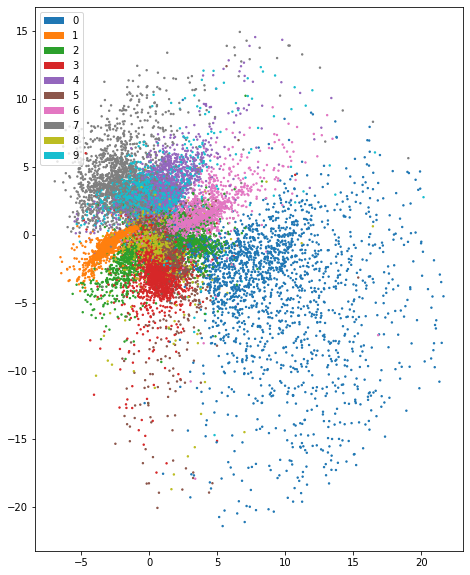

In [78]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in y_train[:20000]]
ax.scatter(bar[:,0],bar[:,1],c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)